In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set_palette(sns.color_palette("Set2"))

In [3]:
filename = 'priv_mcare_f_pay.csv'

In [4]:
data_all = pd.read_csv(filename)

# data with priv_count = 0 and priv_pay_mean not null is stored separately
data_priv0 = data_all[data_all.priv_count == 0].dropna(subset = ['priv_pay_mean'])

# drop rows with priv_count = 0 or null
data = data_all[data_all.priv_count!=0].dropna(subset = ['priv_count', 'priv_pay_mean'])

In [14]:
100*data.shape[0]/data_all.shape[0]

34.754938424663194

In this notebook we try to find the factors that affect the priv_count to determine a new threshold for selecting train and test dataset.
Questions we attempt to answer - 
1. Do the number of claims significantly differ across years? Has there been a decline since 2018?
2. Which types of sites have the highest number of claims?
3. For which procedures do we see high amounts of claims or which we don't? Do we want to use this information to decrease our space of procedures?

## Distribution of priv_count 

From the graph below, the following questions arise - 
1. Which observations do you consider trustworthy/correct?
2. What factors did you take into account when setting the threshold to 50?

In [153]:
priv_count_size = data.groupby(by='priv_count').size().reset_index()
priv_count_size['log_size'] = np.log(priv_count_size[0])
priv_count_size['log_count'] = np.log(priv_count_size['priv_count'])

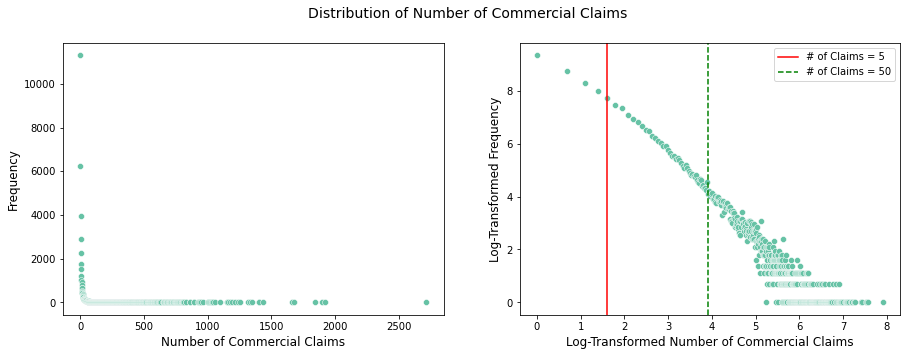

In [221]:
fig, axes = plt.subplots(1,2, figsize = (15,5))

sns.scatterplot(x = 'priv_count', y = 0, data = priv_count_size, ax = axes[0])
axes[0].set_xlabel('Number of Commercial Claims', fontsize = 12)
axes[0].set_ylabel('Frequency', fontsize = 12)



sns.scatterplot(x = 'log_count',y='log_size', data = priv_count_size, ax = axes[1])
axes[1].axvline(x = np.log(5), color = 'red', label = '# of Claims = 5')
axes[1].axvline(x = np.log(50), color = 'green', label = '# of Claims = 50', ls = '--')
axes[1].set_xlabel('Log-Transformed Number of Commercial Claims', fontsize = 12)
axes[1].set_ylabel('Log-Transformed Frequency', fontsize = 12)
# axes[1].set_yticks(np.arange(10))
plt.suptitle('Distribution of Number of Commercial Claims', fontsize = 14)
# plt.grid()
plt.legend()
plt.show()

### Year & Site of Care

Even though there seems to be a decrease in the average value of number of claims per year, the median remains the same. This is because of the presence of too many outliers (that skew mean calculations) as can be seen from the box plot.

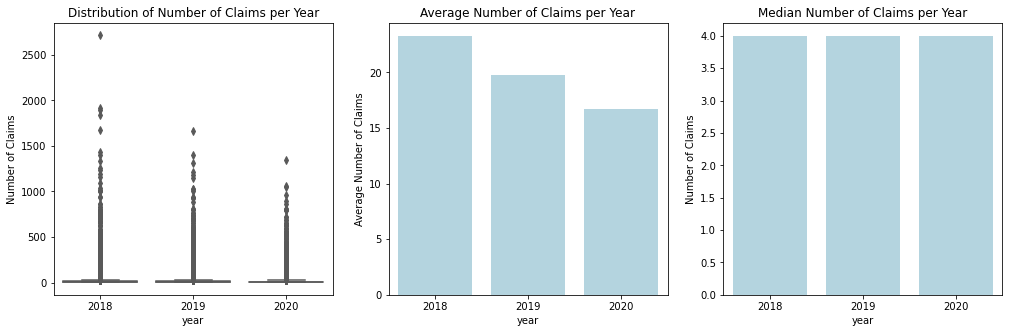

In [5]:
fig, axes = plt.subplots(1,3,figsize = (17,5))

sns.boxplot(x = 'year', y = 'priv_count', data = data, ax = axes[0])
axes[0].set_title('Distribution of Number of Claims per Year')
axes[0].set_ylabel('Number of Claims')

sns.barplot(x = 'year', y = 'priv_count', data = data.groupby(by = 'year').mean()['priv_count'].reset_index(),\
           color = 'lightblue', ax = axes[1])
axes[1].set_title('Average Number of Claims per Year')
axes[1].set_ylabel('Average Number of Claims')

sns.barplot(x = 'year', y = 'priv_count', data = data.groupby(by = 'year').median()['priv_count'].reset_index(),\
           color = 'lightblue', ax = axes[2])
axes[2].set_title('Median Number of Claims per Year')
axes[2].set_ylabel('Number of Claims')

plt.show()

Visualizing the average number of claims per year and per site tells us that on average, claims for inpatient treatments are much lesser than those for outpatient and ASC. We ignore the difference in means across years due to the presence of outliers.

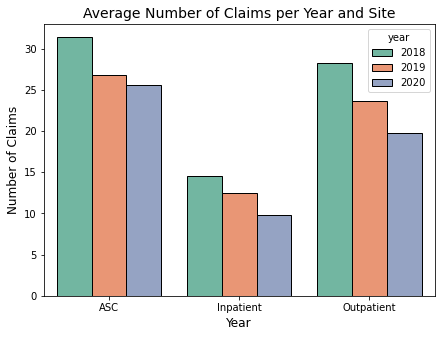

In [7]:
plt.figure(figsize = (7,5))
sns.barplot(x = 'site', y = 'priv_count', hue = 'year', \
            data = data.groupby(by = ['year','site']).mean()['priv_count'].reset_index(), edgecolor = 'black')
plt.xlabel('Year', fontsize = 12)
plt.ylabel('Number of Claims', fontsize = 12)
plt.title('Average Number of Claims per Year and Site', fontsize = 14)

plt.show()

The density plots for the number of claims per year and per site are extremely skewed towards the left indicating the presence of huge amounts of outliers.

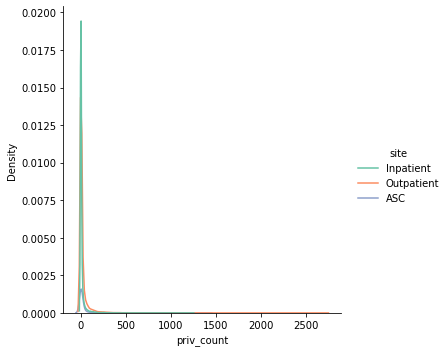

In [8]:
sns.displot(x = 'priv_count', hue = 'site', kind = 'kde', data = data)

### Procedure Group

Out of 51 groups 3 groups for which we have no claim information - bdet, post_TLS_fusion, tavr

In [53]:
no_claim_group = set(data_all.group.unique()) - set(data_priv0.group.unique()) 

In [59]:
data_all[data_all.group.isin(no_claim_group)].groupby('group').mean()[['priv_count','priv_pay_mean']]

,priv_count,priv_pay_mean
group,,
bdet,0.0,NaN
post_TLS_fusion,0.0,NaN
tavr,0.0,NaN


Huge difference in the mean number of claims in procedure groups needs to be taken into account otherwise the train set will not learn the number of claims for some procedure groups. Also there is no proxy for groups unlike MSAs whose characteristics can be generalized based on the state they are part of.

**Question here - Are there are any specific procedures you'd want to focus on?**

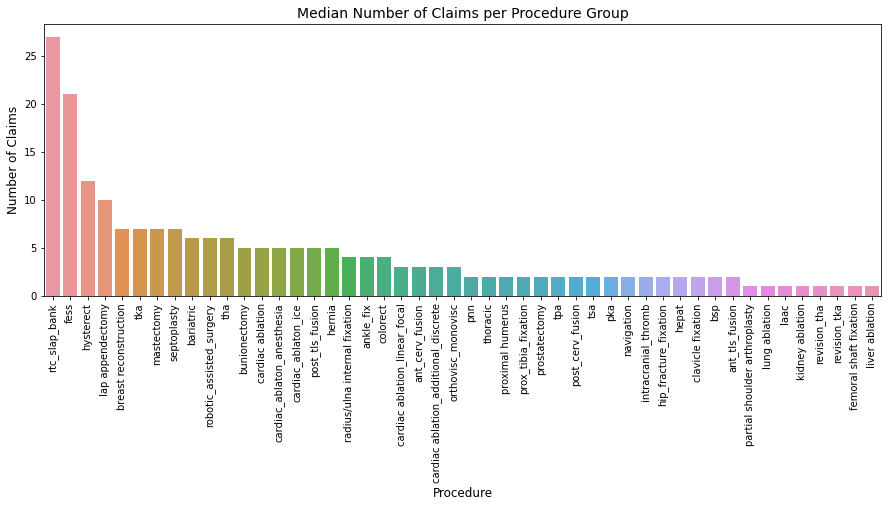

In [132]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'group', y = 'priv_count', \
data = data.groupby(by = ['group']).median()['priv_count'].reset_index().sort_values(by = 'priv_count', ascending = False))
plt.xticks(rotation = 90)
plt.title('Median Number of Claims per Procedure Group', fontsize = 14)
plt.xlabel('Procedure', fontsize = 12)
plt.ylabel('Number of Claims', fontsize = 12)
plt.show()

In [16]:
data_priv50 = data[data.priv_count > 50].groupby(by = 'group').size().to_frame()
data_priv50.columns = ['Num_Claims']
data_priv50['group'] = data_priv50.index
data_priv50.reset_index(drop = True, inplace = True)
data_priv50 = data_priv50.sort_values(by = 'Num_Claims', ascending = False)

In [18]:
data_priv50 = pd.concat([data_priv50, pd.DataFrame({'Num_Claims':[0]*len(set(data.group) - set(data_priv50.group)),\
                           'group':list(set(data.group) - set(data_priv50.group))})])

In [24]:
np.count_nonzero(data_priv50.Num_Claims==0)

12

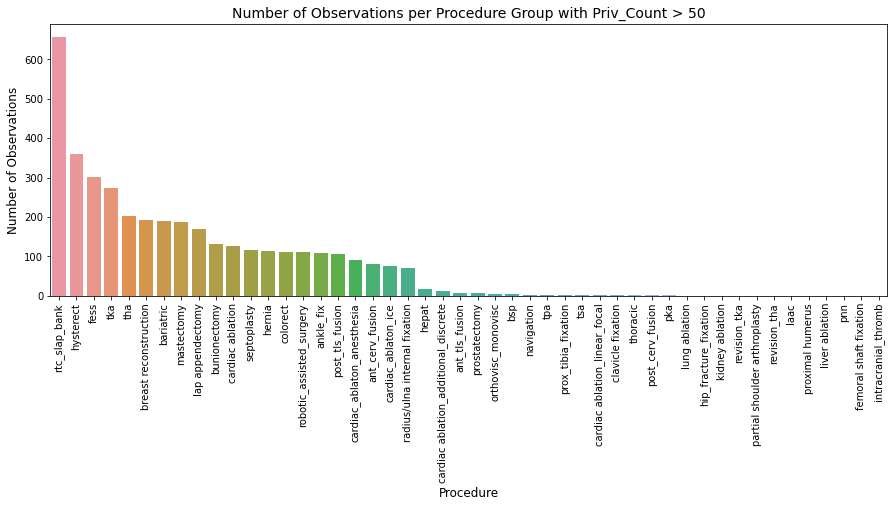

In [12]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'group', y = 'Num_Claims', data = data_priv50)
plt.xlabel('Procedure', fontsize = 12)
plt.ylabel('Number of Observations', fontsize = 12)
plt.title('Number of Observations per Procedure Group with Priv_Count > 50',fontsize = 14)
plt.xticks(rotation = 90)
plt.show()

Very few observations are captured with the threshold of 50- 
1. ASC - 10.11% of total
2. Inpatient - 5.13% of total
3. Outpatient - 10.2% of total

In [188]:
100*data[data.priv_count > 50].groupby(by = 'site').size()/\
data.groupby(by = 'site').size()

site
ASC           10.106252
Inpatient      5.132702
Outpatient    10.182456
dtype: float64

### MSA

Only 174 MSAs out of 407 have an instance where the number of claims was greater than 50 so we need to define a threshold that makes sure we include other MSAs as well

In [312]:
msa50 = data[data.priv_count>50].msa.unique()
msa_not50 = set(data.msa.unique()) - set(msa50)

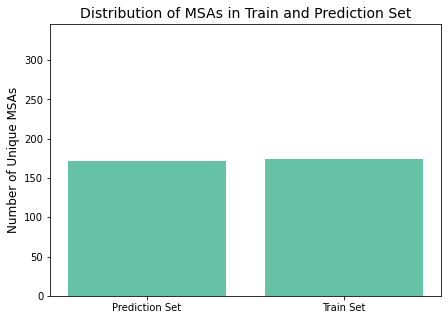

In [324]:
plt.figure(figsize = (7,5))
plt.bar(['Prediction Set','Train Set'],[len(msa_not50), len(msa50)])
plt.ylabel('Number of Unique MSAs', fontsize = 12)
plt.title('Distribution of MSAs in Train and Prediction Set', fontsize = 14)
plt.ylim(0,len(msa50)+len(msa_not50))
plt.show()

Looking at the distribution of observations that don't satisfy the threshold within the train set

In [330]:
msa_train_dist = data[data.msa.isin(msa50)]
observations_dist = \
100*msa_train_dist[msa_train_dist.priv_count>50].groupby('msa').size()/msa_train_dist.groupby('msa').size()

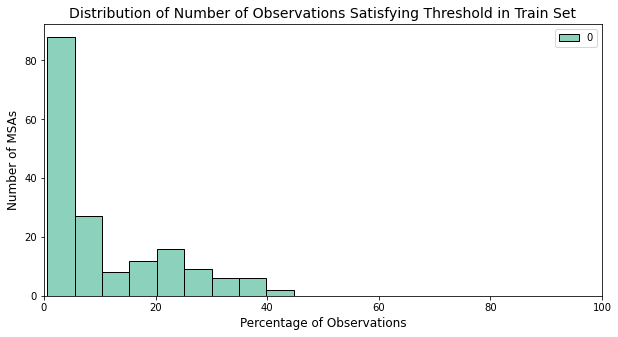

In [335]:
plt.figure(figsize = (10,5))
sns.histplot(observations_dist.to_frame())
plt.xlabel('Percentage of Observations', fontsize = 12)
plt.ylabel('Number of MSAs', fontsize = 12)
plt.title('Distribution of Number of Observations Satisfying Threshold in Train Set', fontsize = 14)
plt.xlim(0,100)
plt.show()

All MSAs, except 2, have more than 60% of observations with the total number of claims less than 50. This means we are discarding more than 60% of data from each MSA while training

In [242]:
msa_priv50[msa_priv50<60]

msa
12060    56.666667
35614    54.838710
dtype: float64

### Outlier Removal

To be able to define a better threshold for selecting data for training and testing purposes we first need to remove outliers within the number of commercial claims. We do so by calculating z-scores and setting a threshold at 3 since most data in a standard normal distribution lies in +/- 3

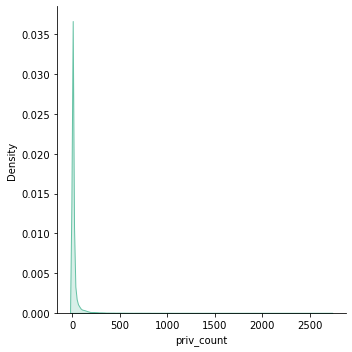

In [99]:
sns.displot(x = 'priv_count', data = data, kind = 'kde', fill = True)
plt.show()

In [255]:
data_temp = data.copy()
# which observations can we trust to be reported correctly?
trust_thresh = 5
data_temp = data_temp[data_temp.priv_count > trust_thresh]

In [256]:
data_temp['priv_zscore'] = (data_temp['priv_count'] - data_temp['priv_count'].mean())/data_temp.priv_count.std()

In [257]:
print('Number of outliers = {}'.format(len(data_temp.priv_zscore[np.abs(data_temp.priv_zscore)>3])))

Number of outliers = 339


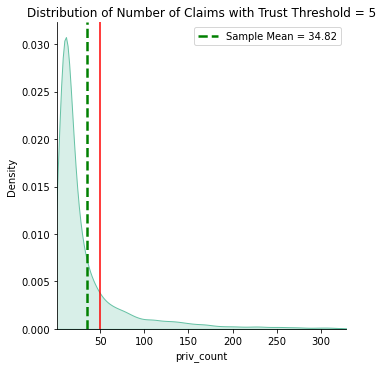

In [261]:
sns.displot(data_temp[np.abs(data_temp.priv_zscore)<3].priv_count, kind = 'kde', fill = True)
plt.axvline(x=data_temp[np.abs(data_temp.priv_zscore)<3].priv_count.mean(),color='green',ls='--', lw=2.5,\
           label = 'Sample Mean = {:.2f}'.format(data_temp[np.abs(data_temp.priv_zscore)<3].priv_count.mean()))
plt.axvline(x = 50, color = 'red')
plt.xlim(1,data_temp[np.abs(data_temp.priv_zscore)<3].priv_count.max())
plt.title('Distribution of Number of Claims with Trust Threshold = {}'.format(trust_thresh))
plt.legend()
plt.show()